In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

In [9]:
id2label = {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
label2id = {'CONTRADICTION': 0, 'NEUTRAL':1, 'ENTAILMENT':2}
conds = ['expt', 'contr']
# Set Scram to true if Analysing performance on ScrambleTests,
# False if on SNLI test set
Scram = True
tasks = ['adjr', 'comp', 'ncon', 'subjv', 'temp', 'verb']

map_name = {'adjr' : 'Adjective-Reference binding', 'comp': 'Comparisons', 
            'temp': 'Temporal ordering', 'subjv': 'Subject-Verb binding',
           'ncon': 'Negating a Condition', 'verb': 'Verb Symmetry', 
            'test': 'SNLI test set', 'dev': 'SNLI dev set'}

def loadresults(name, classifier, tasks, outpaths):
    modelname = name + classifier
    results = {}
    print('\n\n'+'**'*40)
    print("\nLoading tests for {0}...\n".format(modelname))
    print('**'*40 + '\n')
    for task in tasks:
        results[task] = {}
        for j, cond in enumerate(conds): 
            results[task][cond] = {}
            try:
                tempor = np.loadtxt('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname), dtype = int)
                results[task][cond]['est'] = np.array([id2label[x] for x in tempor[j::2]])
            except ValueError:
                with open('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname)) as f:
                    tempor = f.readlines()
                    tempor2 = [id2label[x.strip().upper()] for x in tempor]
                    results[task][cond]['est'] = np.array([id2label[x] for x in tempor2[j::2]])

            tempor = np.loadtxt('{0}{1}_confs_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname))
            results[task][cond]['est_conf'] = np.array(tempor[j::2])
            
            try:
                tempor =  np.loadtxt('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task), dtype = int)
                results[task][cond]['true'] = np.array([id2label[x] for x in tempor[j::2]])
            except ValueError:
                with open('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
                    tempor = f.readlines()
                    tempor2 = [id2label[x.strip().upper()] for x in tempor]
                    results[task][cond]['true'] = np.array([id2label[x] for x in tempor2[j::2]])

            
        
    return results


In [ ]:
toy = False 
TEST_OUT_PATH = './regout/'
outpaths = {}
if toy:
    outpaths['TEST_OUT_PATH'] = './regout/TOY'
    outpaths['TEST_DATA_PATH'] = './testData/toy/'
else:
    outpaths['TEST_OUT_PATH'] = './regout/paired/'
    outpaths['TEST_DATA_PATH'] = './testData/paired/'

if not Scram:
    outpaths['TEST_DATA_PATH'] = './Downloads/SNLI/true/'


names = ['InferSent', 'BOW']
classifiers = [ 'LogReg']
all_results = {}
for name in names:
    for classifier in classifiers:
        all_results[name+classifier] = loadresults(name, classifier, tasks, outpaths)


In [11]:
def plot_hist(data):
    # Create the bar plot
    ax = sns.countplot(
        x="true",
        hue="est",
        order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        data=data)
    return plt.gcf(), ax

ValueError: Grouper and axis must be same length

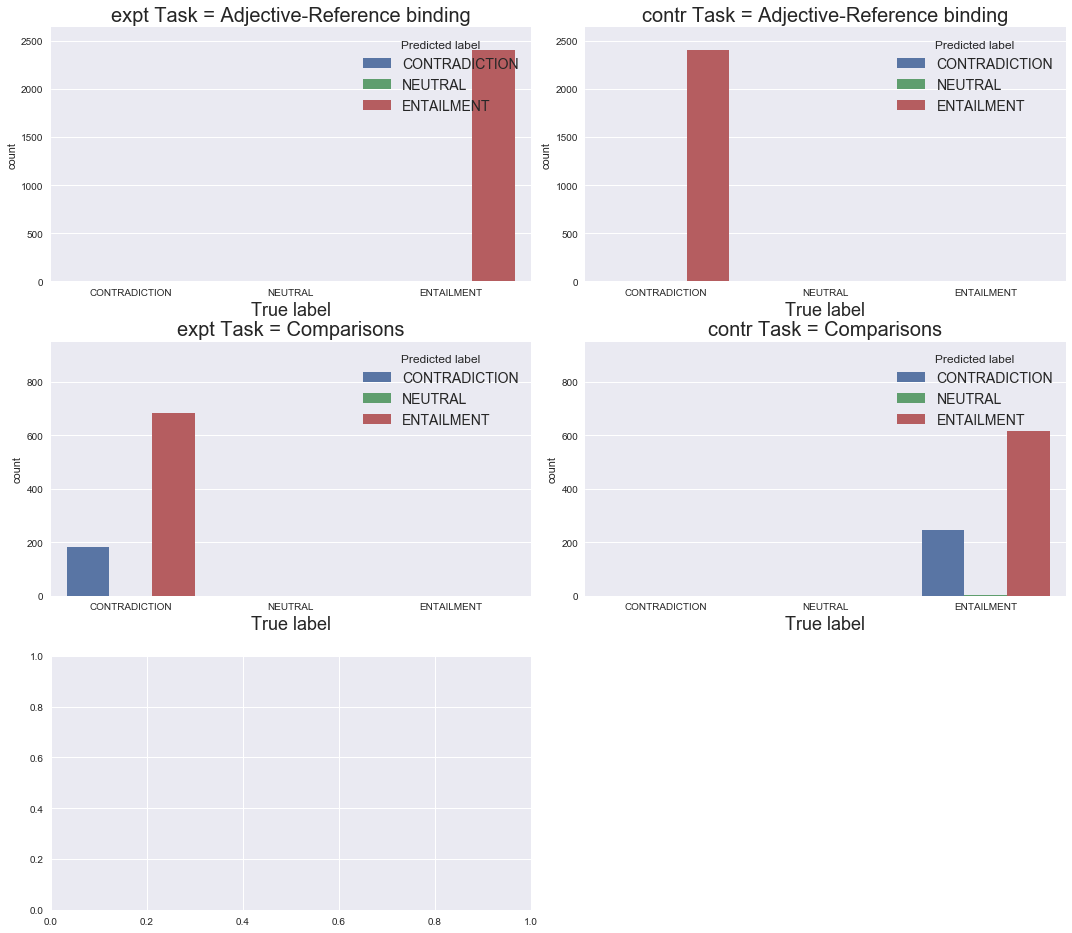

In [12]:
#create figure for histogram split across task and label
for model in all_results:
    plt.figure(figsize=(15, 30))
    for i, task in enumerate(all_results[model]):
        for j, cond in enumerate(conds):
            plt.subplot(6,2,2*i+j+1)
            a, b = plot_hist(all_results[model][task][cond])
            legend = plt.legend(loc='upper right', fontsize = 14, title = "Predicted label")
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
            b.set_title('{0} Task = {1}'.format(cond, map_name[task]), fontsize = 20)
            lim = max(np.concatenate((np.bincount([label2id[x.strip()] for x in all_results[model][task][cond]['est']]), 
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task][cond]['true']])
                                     )))*1.1
            b.set_ylim([0,lim])
            b.set_xlabel("True label", fontsize = 18)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)


In [ ]:
n_task = 0
N = 5
tasks0 = ['comp', 'ncon', 'subjv', 'verb']

for task in tasks0:
    n_task +=1 
    
    with open("{0}s1.{1}".format(outpaths['TEST_DATA_PATH'], task))as f:
        sents_A = f.readlines()
    with open('{0}s2.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
        sents_B = f.readlines()

    conf_I = {}
    est_I = {}
    est_B = {}
    tru = {}
    conf_I_intrue = {} 
    for cond in conds:
        tru[cond] = np.array(all_results['BOW'+classifier][task][cond]['true'])
        est_I[cond] = np.array(all_results['InferSent'+classifier][task][cond]['est'])
        est_B[cond] = np.array(all_results['BOW'+classifier][task][cond]['est'])
        conf_I_intrue[cond] = np.array([100*all_results['InferSent'+classifier][task][cond]['est_conf'][i][label2id[j]] for i, j in enumerate(tru[cond])])
        conf_I[cond] = np.array([100*all_results['InferSent'+classifier][task][cond]['est_conf'][i][label2id[j]] for i, j in enumerate(est_I[cond])])
        
    diff_con = conf_I_intrue['expt'] + conf_I_intrue['contr']
    
    est_B = np.array(all_results['BOW'+classifier][task]['expt']['est'])
    conf_B = np.array([100*all_results['BOW'+classifier][task]['expt']['est_conf'][i][label2id[j]] for i, j in enumerate(est_B)])
    order = np.argsort(-diff_con)
    
    filt = tru['expt'] != tru['contr']
    
    print('*'*66)
    print("TASK: ", map_name[task])
    print('*'*66, '\n')
    disp = 0
    for disp_i in order: 
        if (disp < N) & (filt[disp_i]) :
            for j, cond in enumerate(conds):
                print("Pair {0} :".format(j))
                print(sents_A[2*disp_i + j])
                print(sents_B[2*disp_i + j])
                print("True: ", tru[cond][disp_i], "\nEstimated InferSent: ", est_I[cond][disp_i], "\t IS confidence", conf_I[cond][disp_i])
                print("BOW: ", est_B[disp_i], "\t BOW conf", conf_B[disp_i])
                print("\n", "-"*40, "\n")

            disp += 1
   

/Users/cocolab/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


IndexError: index 1200 is out of bounds for axis 0 with size 1200

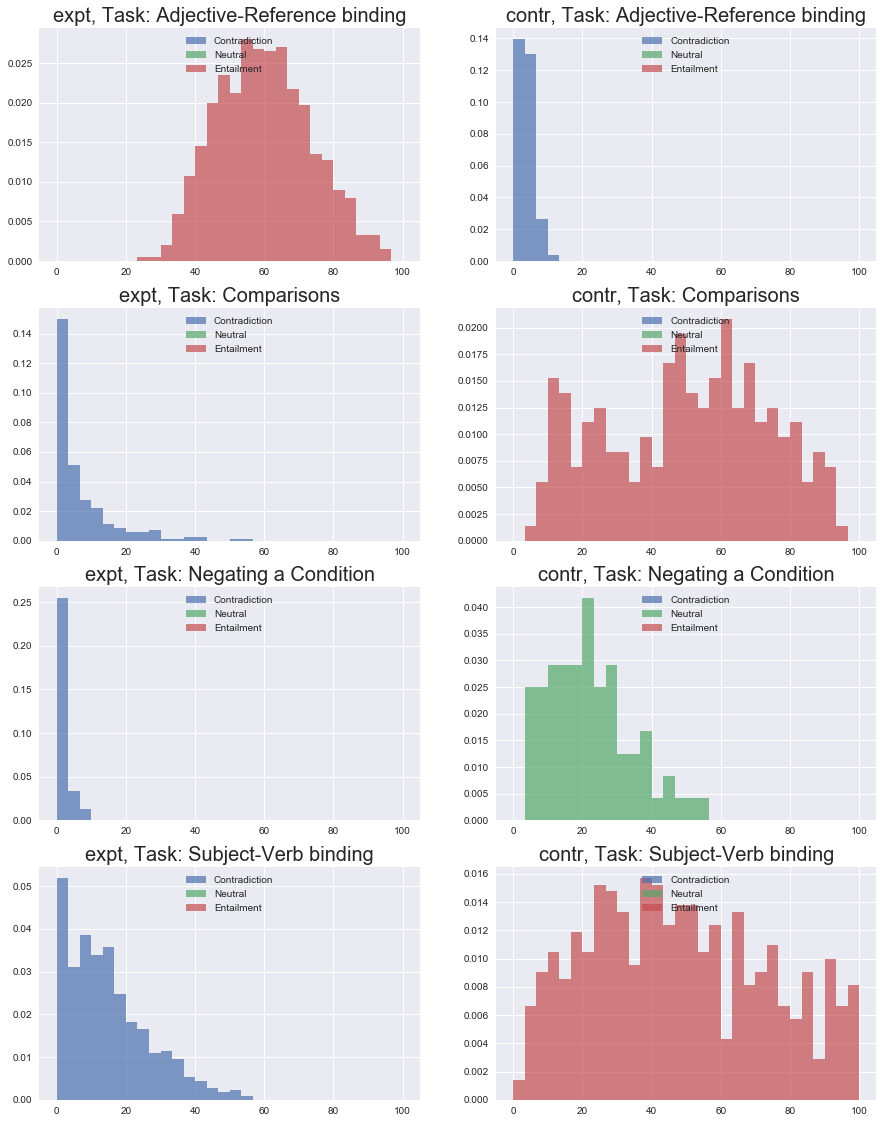

In [13]:
#create figure for confidences split across task and label
for name in ['BOW']:
    plt.figure(figsize=(15,30))
    for i, task in enumerate(tasks):
        for j, cond in enumerate(conds):
        
            tru = np.array(all_results[name+classifier][task][cond]['true'])
            est = np.array(all_results[name+classifier][task][cond]['est'])
            
            conf_intrue = np.array([100*all_results[name+classifier][task][cond]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
            
            plt.subplot(6,2, 2*i + j + 1)
            plt.hist(conf_intrue[tru == 'CONTRADICTION'], range = (0,100), normed = True, bins = 30, label = 'Contradiction', alpha = 0.7)
            plt.hist(conf_intrue[tru == 'NEUTRAL'], range = (0,100), normed = True, bins = 30, label = 'Neutral', alpha = 0.7)
            plt.hist(conf_intrue[tru == 'ENTAILMENT'], range = (0,100), normed = True, bins = 30, label = 'Entailment', alpha = 0.7)
            
            plt.legend(loc='upper center', fontsize = 10)
            plt.title('{0}, Task: {1}'.format(cond, map_name[task]), fontsize = 20)
            
